In [1]:
import torch, torchvision, json, os, PIL
import numpy as np
from sklearn.preprocessing import normalize
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

In [2]:
with open("../data/image_info_data.json") as f:
    image_info = json.load(f)

In [3]:
resnet50 = torch.nn.Sequential(*list(torchvision.models.resnet50(pretrained = True).children())[:-1])
resnet50.eval()
def get_feature(image_batch):
    # image_batch shape: [batch_size, 3, image_size, image_size]
    with torch.no_grad():
        return resnet50(image_batch).squeeze(-1).squeeze(-1)

In [4]:
def load_image(image_path):
    try:
        image = np.asarray(Image.open(image_path))
        return image
    except PIL.UnidentifiedImageError:
        return None

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 data,
                 data_folder,
                 config):
        self.data = data
        self.DATA_FOLDER = data_folder
        self.error_index = set([])

        #mean=[0.485, 0.456, 0.406]
        #std=[0.229, 0.224, 0.225]
        imsize, mean, std = config["image_size"], config["mean"], config["std"]
        self.imsize = imsize
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Resize((imsize, imsize)),
                                             transforms.Normalize(mean=mean, std=std)])


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if index in self.error_index: return torch.zeros((3, self.imsize, self.imsize))

        image_path = os.path.join(self.DATA_FOLDER, self.data[index]["id"] + ".jpg")
        image = load_image(image_path)

        if image is None or image.shape[-1] != 3:
            self.error_index.add(index)
            return torch.zeros((3, self.imsize, self.imsize))

        return self.transform(image)

In [5]:
CATEGORY = "4"
data = image_info[CATEGORY]
data_folder = "../data/image_folder"
config = {
    "image_size": 64,
    "mean":[0.485, 0.456, 0.406],
    "std":[0.229, 0.224, 0.225]
}

In [6]:
image_dataset = ImageDataset(data = data[:],
                            data_folder = data_folder,
                            config = config)

dataloader = torch.utils.data.DataLoader(image_dataset, 
                                        batch_size = 128,
                                        shuffle = False,
                                        num_workers = 4)

In [7]:
all_features = torch.zeros((len(dataloader.dataset), 2048))
for i, batch in tqdm(enumerate(dataloader), total = len(dataloader)):
    features = get_feature(batch)
    all_features[i * 128:i * 128 + 128] = features

  0%|          | 0/124 [00:00<?, ?it/s]/anaconda/envs/azureml_py36/lib/python3.6/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its 

In [8]:
from sklearn.ensemble import IsolationForest


predictions = IsolationForest(random_state=0, 
                              max_features = 20,
                              contamination=5/150).fit_predict(normalize(all_features.numpy()))

In [9]:
outliers_id = []
for i, l in enumerate(predictions):
    if l == -1:
        outliers_id.append(i)

In [10]:
len(outliers_id)

526

In [11]:
import matplotlib.pyplot as plt
def show_img(img_id):
    fig,ax = plt.subplots(1,1)
    image_file = os.path.join(data_folder, img_id + ".jpg")
    ax.imshow(load_image(image_file))

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


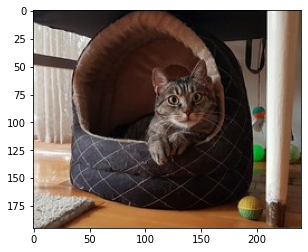

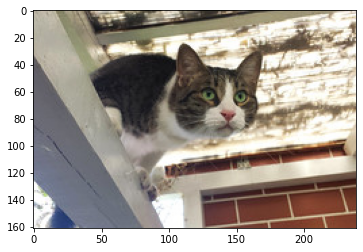

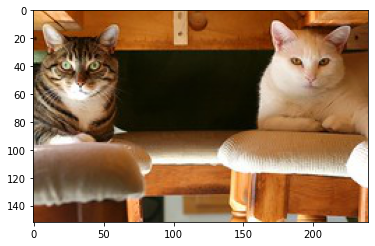

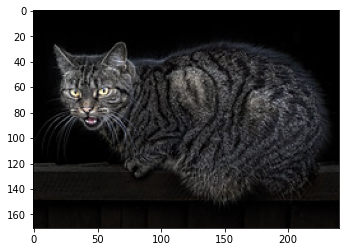

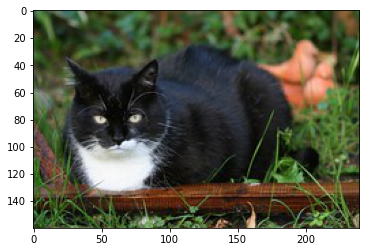

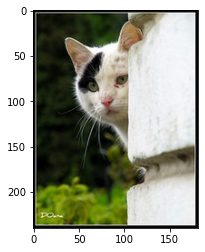

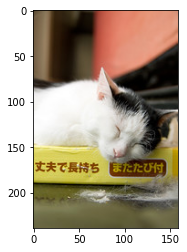

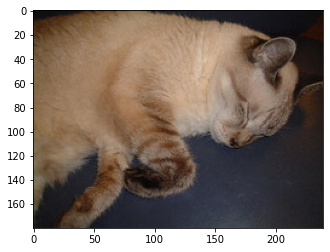

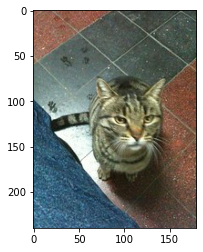

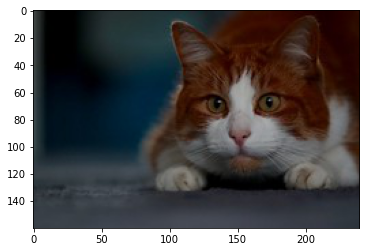

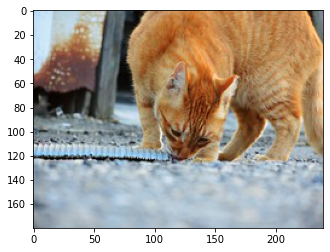

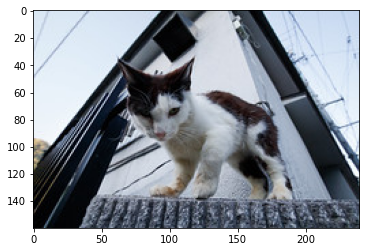

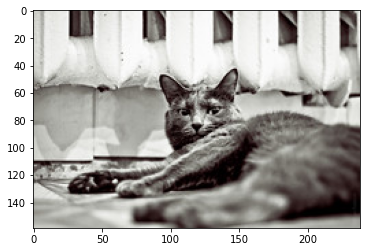

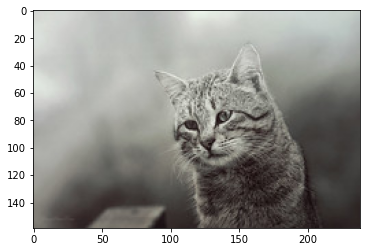

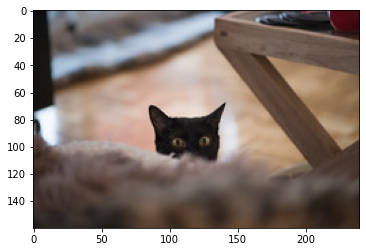

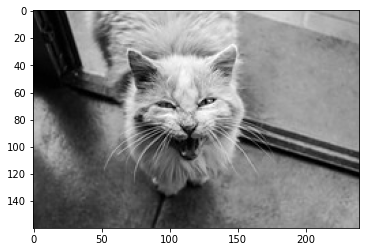

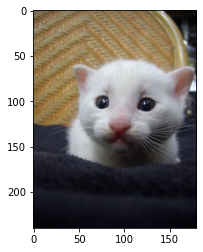

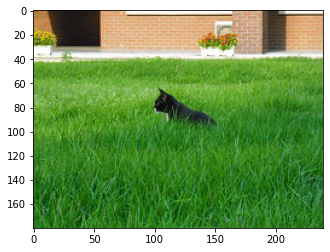

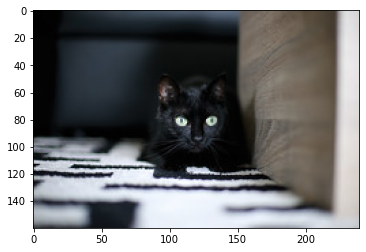

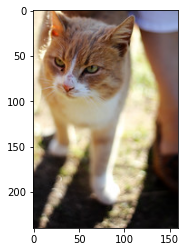

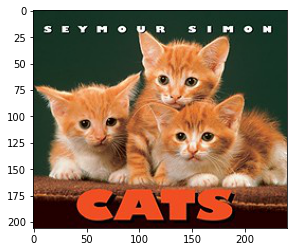

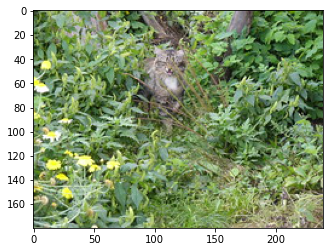

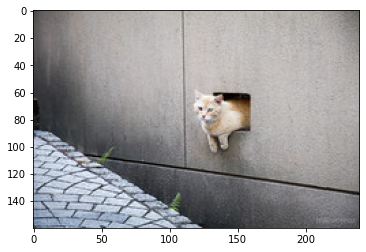

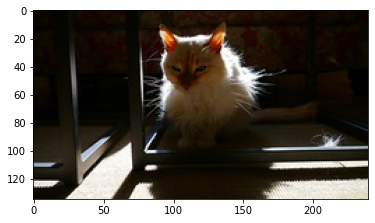

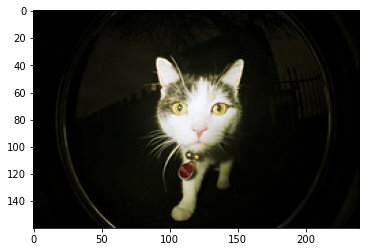

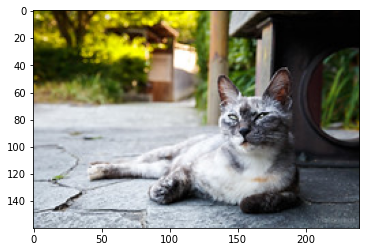

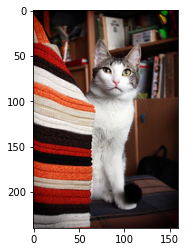

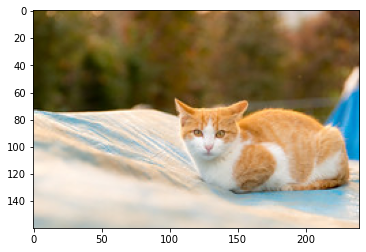

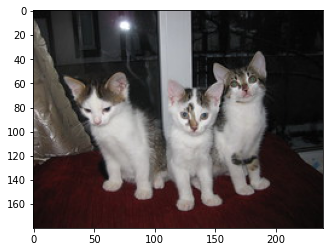

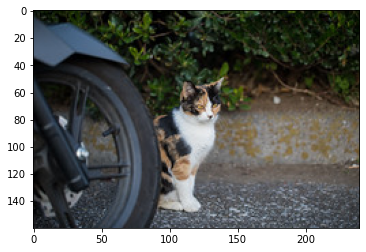

In [12]:
for o_id in outliers_id[:30]:
    show_img(data[o_id]["id"])

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


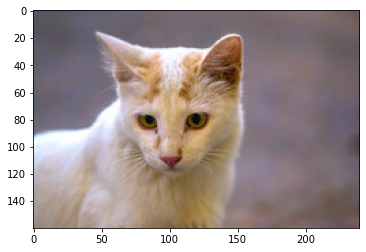

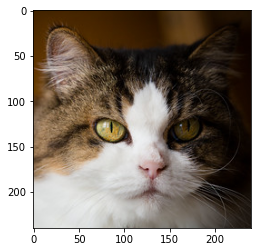

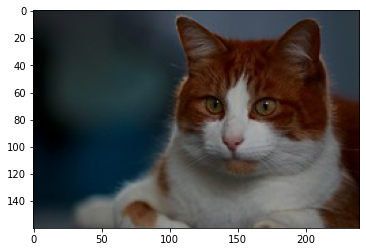

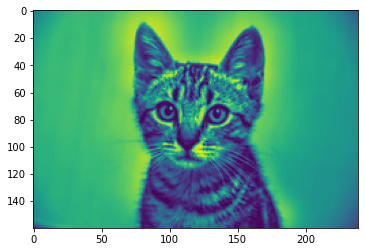

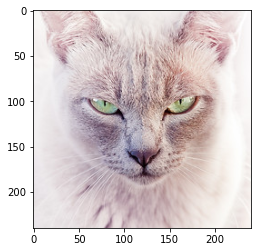

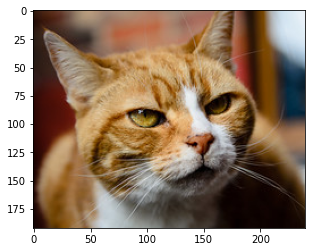

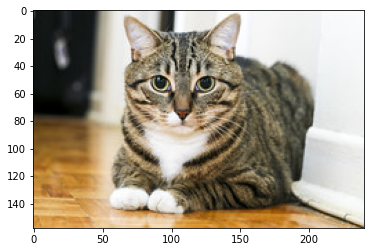

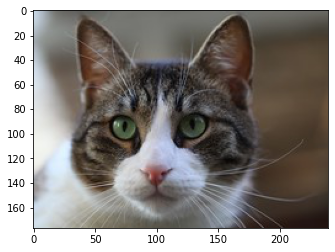

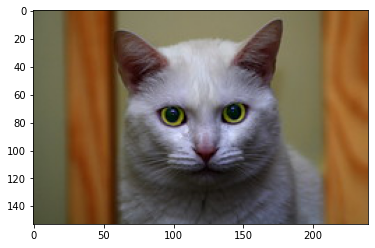

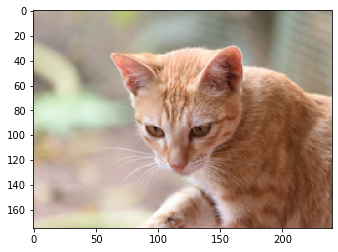

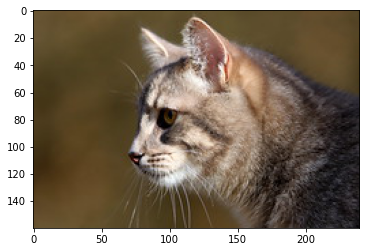

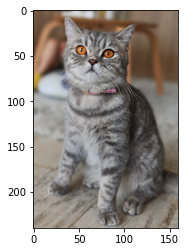

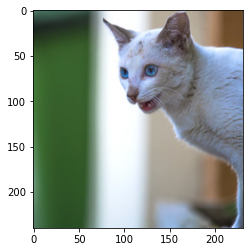

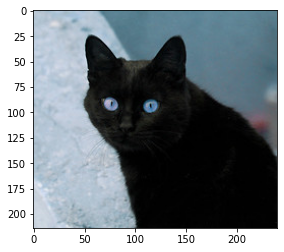

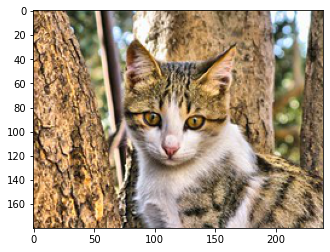

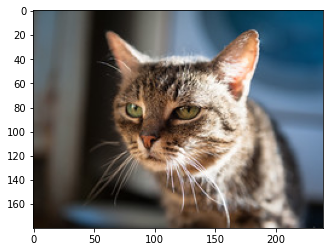

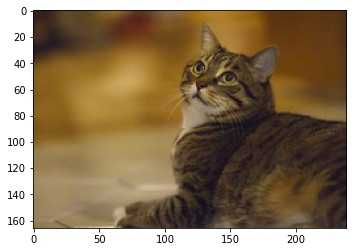

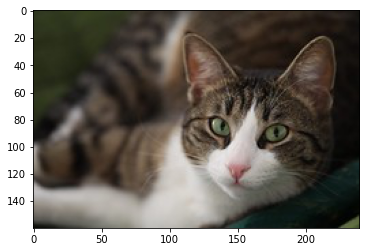

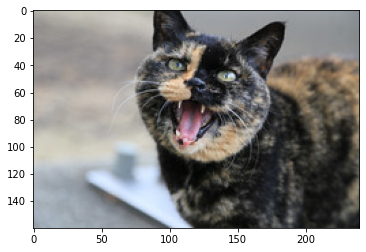

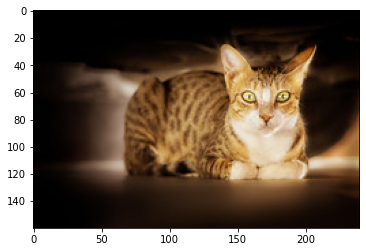

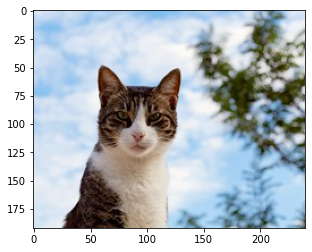

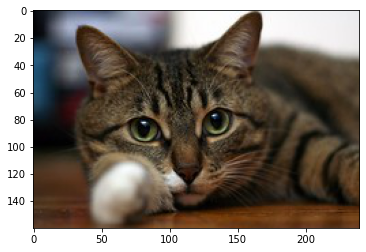

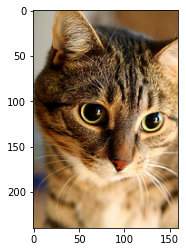

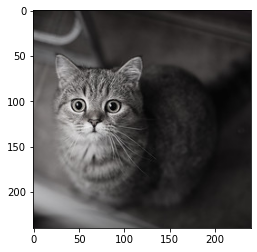

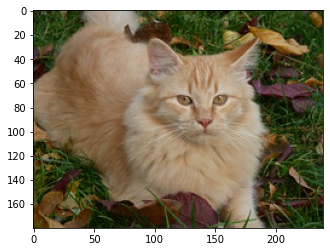

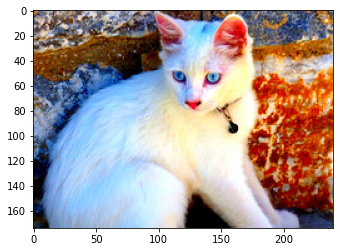

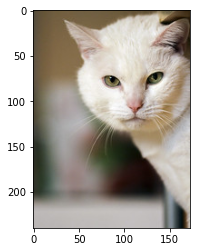

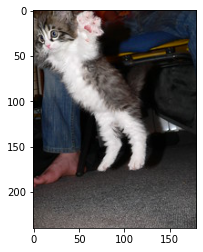

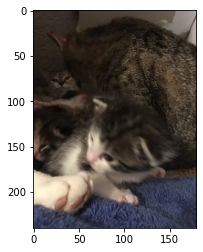

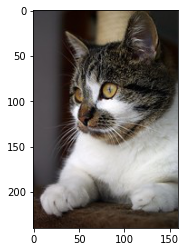

In [13]:
count = 0
for i in range(len(data)):
    if i in outliers_id: continue
    dp = data[i]
    if count >= 30: break
    show_img(dp["id"])
    count += 1

In [14]:
with open(f"../data/preprocessing/indices2remove_category{CATEGORY}.json", "w") as f:
    json.dump(outliers_id, f)